# DATA 620 - Assignment 3

https://neo4j.com/docs/api/python-driver/current/api.html#

http://www.solasistim.net/posts/neo4j_to_networkx/

In [288]:
!pip install neo4j

In [289]:
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
from neo4jconfig import neo4j_auth
%matplotlib inline

#### Connect to Neo4j Movie database

In [273]:
gdb = GraphDatabase.driver(uri=neo4j_auth['uri'],auth=(neo4j_auth['user'],neo4j_auth['password']), encrypted=False)
session = gdb.session()

In [274]:
# Sample query
q1 = "MATCH (n) return (n) LIMIT 10"
nodes = session.run(q1)

for node in nodes:
    print(node)

<Record n=<Node id=0 labels={'Movie'} properties={'title': 'The Matrix', 'tagline': 'Welcome to the Real World', 'released': 1999}>>
<Record n=<Node id=1 labels={'Person'} properties={'name': 'Keanu Reeves', 'born': 1964}>>
<Record n=<Node id=2 labels={'Person'} properties={'name': 'Carrie-Anne Moss', 'born': 1967}>>
<Record n=<Node id=3 labels={'Person'} properties={'name': 'Laurence Fishburne', 'born': 1961}>>
<Record n=<Node id=4 labels={'Person'} properties={'name': 'Hugo Weaving', 'born': 1960}>>
<Record n=<Node id=5 labels={'Person'} properties={'name': 'Lilly Wachowski', 'born': 1967}>>
<Record n=<Node id=6 labels={'Person'} properties={'name': 'Lana Wachowski', 'born': 1965}>>
<Record n=<Node id=7 labels={'Person'} properties={'name': 'Joel Silver', 'born': 1952}>>
<Record n=<Node id=8 labels={'Person'} properties={'name': 'Emil Eifrem', 'born': 1978}>>
<Record n=<Node id=9 labels={'Movie'} properties={'title': 'The Matrix Reloaded', 'tagline': 'Free your mind', 'released': 200

In [291]:
# Query Person names
result = session.run("MATCH (a:Person) RETURN a.name AS name")
names = [record["name"] for record in result]

In [293]:
names

['Keanu Reeves',
 'Carrie-Anne Moss',
 'Laurence Fishburne',
 'Hugo Weaving',
 'Lilly Wachowski',
 'Lana Wachowski',
 'Joel Silver',
 'Emil Eifrem',
 'Charlize Theron',
 'Al Pacino',
 'Taylor Hackford',
 'Tom Cruise',
 'Jack Nicholson',
 'Demi Moore',
 'Kevin Bacon',
 'Kiefer Sutherland',
 'Noah Wyle',
 'Cuba Gooding Jr.',
 'Kevin Pollak',
 'J.T. Walsh',
 'James Marshall',
 'Christopher Guest',
 'Rob Reiner',
 'Aaron Sorkin',
 'Kelly McGillis',
 'Val Kilmer',
 'Anthony Edwards',
 'Tom Skerritt',
 'Meg Ryan',
 'Tony Scott',
 'Jim Cash',
 'Renee Zellweger',
 'Kelly Preston',
 "Jerry O'Connell",
 'Jay Mohr',
 'Bonnie Hunt',
 'Regina King',
 'Jonathan Lipnicki',
 'Cameron Crowe',
 'River Phoenix',
 'Corey Feldman',
 'Wil Wheaton',
 'John Cusack',
 'Marshall Bell',
 'Helen Hunt',
 'Greg Kinnear',
 'James L. Brooks',
 'Annabella Sciorra',
 'Max von Sydow',
 'Werner Herzog',
 'Robin Williams',
 'Vincent Ward',
 'Ethan Hawke',
 'Rick Yune',
 'James Cromwell',
 'Scott Hicks',
 'Parker Posey',
 

In [298]:
# Query all the data
records = session.run("MATCH (n) OPTIONAL MATCH (n)-[r]->() RETURN n, r")
# r['r'] for links, r['n'] for node
#Only accessible through iteration

#for rec in records:
#    print(rec['r'])

In [306]:
# Used in graphing
labels = []
ids = []

In [307]:
def rec2graph(rs):
    graph = networkx.MultiDiGraph()
    
    for record in rs:
        node = record['n']
        if node:
            nx_properties = {}
            graph.add_node(node.id, **nx_properties)
            
            ids.append(node.id)
            labels.append(node.get('name'))

        relationship = record['r']
        if relationship is not None:   # essential because relationships use hash val
            graph.add_edge(
                relationship.start_node.id, relationship.end_node.id, key=relationship.type
            )
            
    return graph

In [308]:
records = session.run("MATCH (n) OPTIONAL MATCH (n)-[r]->() RETURN n, r")
g = rec2graph(records)
print(nx.info(g))

Name: 
Type: MultiDiGraph
Number of nodes: 171
Number of edges: 253
Average in degree:   1.4795
Average out degree:   1.4795


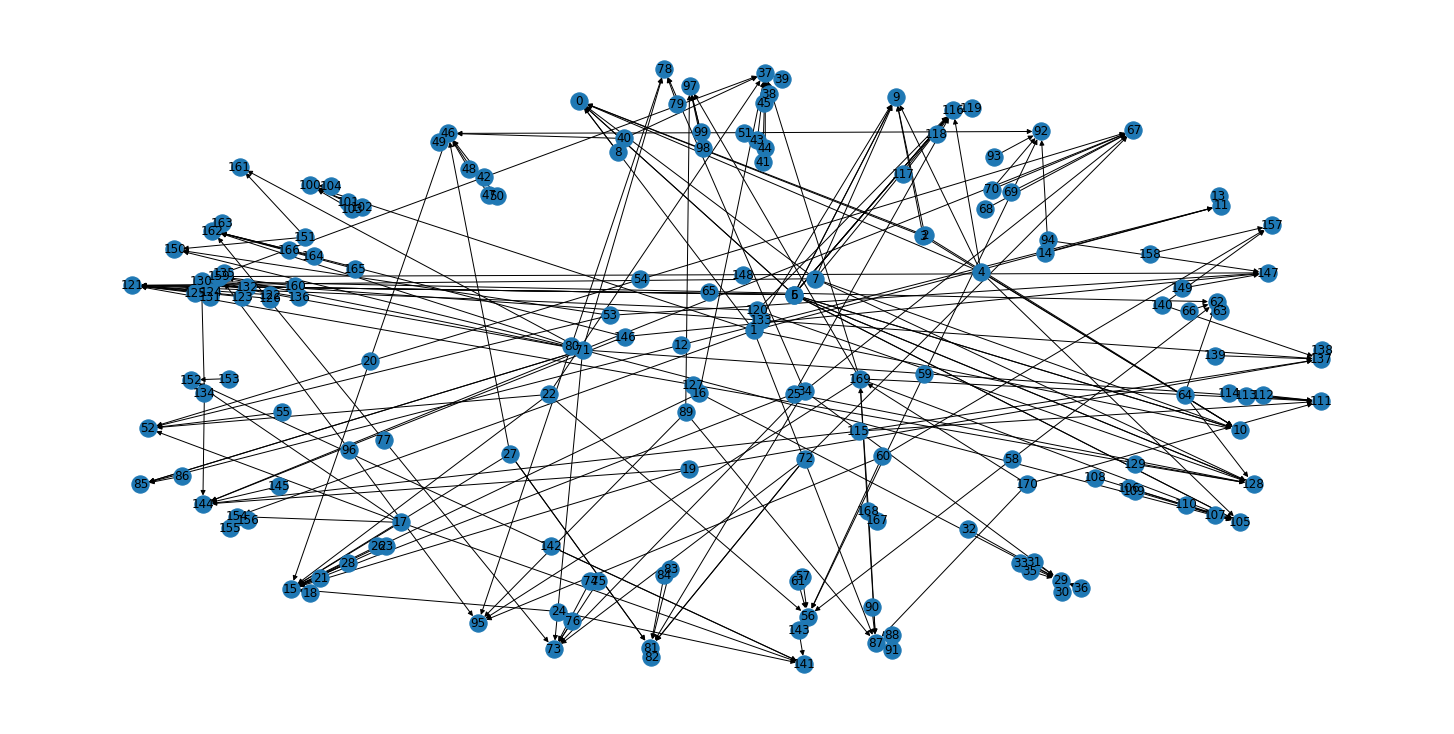

In [309]:
# Simple graph
networkx.draw(g, with_labels=True)

In [310]:
graph_pos = nx.spring_layout(g)

In [311]:
labels = dict(zip(ids,labels))

In [312]:
plt.rcParams['figure.figsize'] = [20, 10]

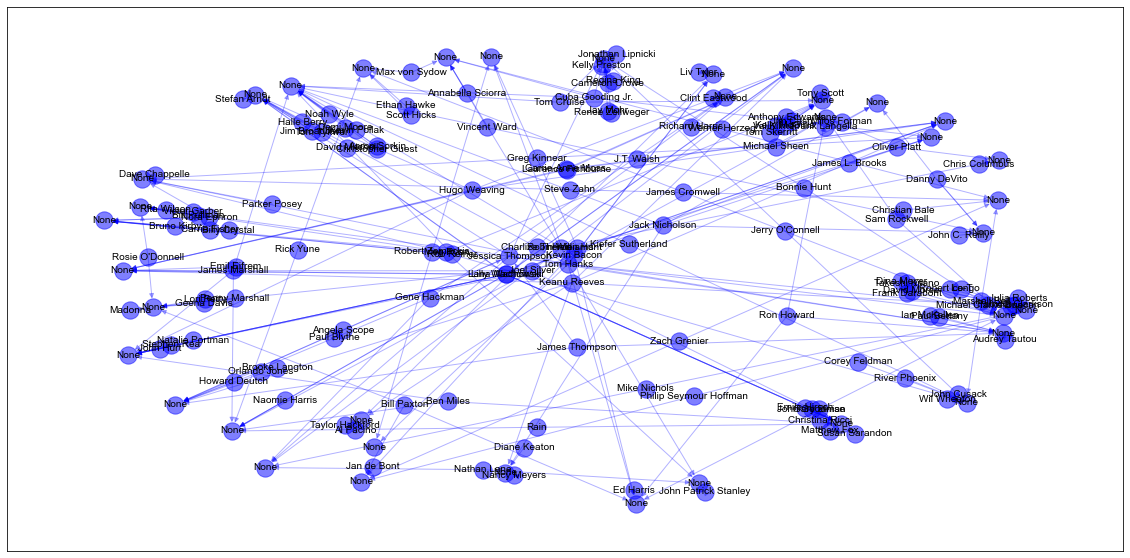

In [313]:
fig = nx.draw_networkx_nodes(g, graph_pos, alpha=.5, node_color='blue')
fig = nx.draw_networkx_edges(g, graph_pos, width=1, alpha=.3, edge_color='blue')
fig = nx.draw_networkx_labels(g, graph_pos, labels=labels, font_size=10, font_family='Arial')